# VisioTextual Insight Engine for Research Papers (VTIERP)

# VTIERP: Exploring Multimodal RAG for Enhanced Research Paper Understanding

## 1. Introduction

Research papers are rich sources of information, presenting findings not only through text but also critically through visual elements like figures, diagrams, and tables. Traditional RAG (Retrieval Augmented Generation) systems often focus solely on textual content, potentially missing crucial insights conveyed visually. This notebook documents the exploration and development of a VisioTextual Insight Engine for Research Papers (VTIERP), aiming to create a more holistic understanding by integrating information from both textual and visual modalities.

## 2. Problem Statement

How can we effectively extract, represent, and query information from both the textual content and the visual elements (and their descriptions/captions) within research PDFs to answer complex user queries that may require cross-modal understanding?

## 3. Objectives

*   Explore methods for robust text extraction from PDFs.
*   Investigate techniques for identifying and extracting visual elements (images, diagrams, tables).
*   Develop a strategy for generating meaningful textual descriptions for these visual elements, especially when explicit captions are missing or insufficient (simulating advanced VLM capabilities).
*   Design a RAG pipeline that can leverage both textual chunks and visual element descriptions.
*   Evaluate the approach with sample research papers and complex queries.
*   Utilize Langchain and LangGraph for building the RAG system and agentic control flow.
*   Employ Google Gemini models for embedding, auxiliary tasks (like summarization or simulated VLM descriptions), and final answer generation.

In [20]:
# Essential imports, confuguration and also initialization of models and directories for the advanced version of the script
import os
import shutil
import uuid
import io
import re
import math # For get_pymupdf_drawing_clusters
from PIL import Image
from tqdm.auto import tqdm # For progress bars if you like
from collections import defaultdict # For caption_to_visual_parts_map
import base64 # For image_to_base64

import fitz # PyMuPDF

# Langchain and related imports
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.vectorstores import Chroma
from langchain.docstore.document import Document
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List, Dict, Tuple, Optional, Any, Set # For type hinting

# Unstructured (optional, for cleaning/OCR)
try:
    from unstructured.cleaners.core import clean as unstruct_clean, clean_extra_whitespace as unstruct_clean_ws
    UNSTRUCTURED_AVAILABLE = True
except ImportError:
    UNSTRUCTURED_AVAILABLE = False
    print("Warning: Unstructured.io not found. Basic text cleaning will be used. OCR features might be limited.")


# --- Configuration ---
NOTEBOOK_DIR = os.getcwd() # Important for path joining

# API Key (ensure this is set)
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    from getpass import getpass
    GOOGLE_API_KEY = getpass("Enter Google API Key: ")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# PDF Files
PDF_PATHS = ["AAG.pdf", "Self_rewarding_VLLM.pdf"] # Ensure these files are in NOTEBOOK_DIR or provide full paths

# Output Directories for Exploration
EXPLORATION_OUTPUT_BASE = os.path.join(NOTEBOOK_DIR, "exploration_outputs") # New versioned output
IMAGE_SAVE_PARENT_DIR = os.path.join(EXPLORATION_OUTPUT_BASE, "extracted_elements")
CHROMA_TEXT_PATH_NOTEBOOK = os.path.join(EXPLORATION_OUTPUT_BASE, "chroma_db_text")
CHROMA_IMAGE_DESC_PATH_NOTEBOOK = os.path.join(EXPLORATION_OUTPUT_BASE, "chroma_db_img_desc")

# Clean up previous exploration run outputs
if os.path.exists(EXPLORATION_OUTPUT_BASE):
    shutil.rmtree(EXPLORATION_OUTPUT_BASE)
os.makedirs(IMAGE_SAVE_PARENT_DIR, exist_ok=True)
os.makedirs(CHROMA_TEXT_PATH_NOTEBOOK, exist_ok=True)
os.makedirs(CHROMA_IMAGE_DESC_PATH_NOTEBOOK, exist_ok=True)


# LLM/VLM Configuration from your notebook (or simplified for exploration)
MAX_IMAGES_TO_LLM_FINAL = 3
MAX_ELEMENTS_FOR_VLM_DESCRIPTION_PER_PDF_EXPLORE = 3 # Keep low for notebook speed
RENDER_DPI_PYMUPDF = 150
MIN_VISUAL_WIDTH_PYMUPDF = 30
MIN_VISUAL_HEIGHT_PYMUPDF = 30
TEXT_BLOCK_MIN_AREA_FOR_OBSTRUCTION = 100
DRAWING_CLUSTER_MAX_DIST_FACTOR = 0.03
OCR_DPI = 300
MIN_OCR_TEXT_LENGTH_FOR_SCANNED_PDF = 100

# Initialize LLMs and Embeddings
llm_rag = None
llm_aux = None # This will be used for VLM-like descriptions
embeddings = None
try:
    # Match models from your original notebook if possible and available
    llm_rag = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", google_api_key=GOOGLE_API_KEY, temperature=0.0, max_output_tokens=8192)
    llm_aux = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", google_api_key=GOOGLE_API_KEY, temperature=0.1, max_output_tokens=4096) # Ensure this model can handle image inputs if you test that part early
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=GOOGLE_API_KEY)
    print(f"Gemini RAG: {llm_rag.model}, Aux: {llm_aux.model}, Embeddings: {embeddings.model} initialized.")
except Exception as e:
    print(f"CRITICAL Error initializing Gemini models/embeddings: {e}. Notebook execution might fail.")
    # You might want to raise e here or handle it gracefully

print("Setup Complete.")


Gemini RAG: models/gemini-2.5-flash-preview-05-20, Aux: models/gemini-2.5-flash-preview-05-20, Embeddings: models/text-embedding-004 initialized.
Setup Complete.


## 4. Data Acquisition & Preparation

For this exploration, we will use the following publicly available research papers:
*   `AAG.pdf` (Analogy-Augmented Generation)
*   `Self_rewarding_VLLM.pdf` (Self-Rewarding Vision Language Models)

These papers contain a good mix of text, complex diagrams, and tables, making them suitable for testing our multimodal approach.


## 5 Core Utility and Helper Functions

Before we begin the extraction process, let's define the core helper functions that will be used throughout this notebook.

### 5.1: Text Processing and Image Utilities

In [45]:
def clean_parsed_text(text: str) -> str:
    """Cleans text by removing extra whitespace and handling ligatures."""
    if not text: return ""
    if UNSTRUCTURED_AVAILABLE:
        try:
            text = unstruct_clean(text, bullets=False, extra_whitespace=False, dashes=False, trailing_punctuation=False)
            text = unstruct_clean_ws(text)
        except Exception: # Fallback
            text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("ﬁ", "fi").replace("ﬂ", "fl")
    return text.strip()

def image_to_base64(image_path: str) -> Tuple[Optional[str], Optional[str]]:
    """Converts an image file to a base64 string and returns its MIME type."""
    if not os.path.exists(image_path):
        print(f"Warning: Image path does not exist: {image_path}")
        return None, None
    try:
        with Image.open(image_path) as img:
            fmt = img.format.lower() if img.format else 'png'
            save_format = fmt if fmt in ["jpeg", "png", "gif", "webp"] else "PNG"
            if save_format.upper() == "JPEG" and img.mode == "RGBA": img = img.convert("RGB")
            bio = io.BytesIO()
            img.save(bio, format=save_format)
            img_bytes = bio.getvalue()
            mime_type = f"image/{save_format.lower()}"
            if save_format.upper() == "JPEG": mime_type = "image/jpeg"
        return base64.b64encode(img_bytes).decode('utf-8'), mime_type
    except Exception as e:
        print(f"Error converting image to base64 for {os.path.basename(image_path)}: {e}")
        return None, None

# Global counter for VLM descriptions for this notebook run
images_described_this_run_count = 0

def generate_detailed_image_description(
    image_path: str,
    element_type: str = "visual element",
    # llm_vlm: ChatGoogleGenerativeAI = llm_aux # Use the globally defined llm_aux
    max_vlm_calls_limit: int = MAX_ELEMENTS_FOR_VLM_DESCRIPTION_PER_PDF_EXPLORE
) -> str:
    """
    Generates a detailed description of an image using a multimodal LLM (VLM).
    Uses the global images_described_this_run_count and llm_aux.
    """
    global images_described_this_run_count # To modify the global counter
    if not llm_aux: return f"VLM (aux_llm) not initialized for {os.path.basename(image_path)}."

    if images_described_this_run_count >= max_vlm_calls_limit:
        # print(f"VLM description limit ({max_vlm_calls_limit}) reached for this run. Skipping VLM for {os.path.basename(image_path)}")
        return f"Visual Element ({element_type}): {os.path.basename(image_path)}. VLM description skipped due to limit."

    try:
        img_base64, mime_type = image_to_base64(image_path)
        if not img_base64: return f"Could not load image {os.path.basename(image_path)} for VLM."

        prompt_text = (f"Expert document analyst: Analyze this {element_type} from a research paper. Describe its key visual components, structure, any text present within it, and its apparent purpose or the information it conveys. "
                       f"For Tables: describe columns, data types, and notable trends. For Diagrams/Charts: describe type, axes, trends, and flow. Provide a concise, comprehensive summary suitable for Q&A.")

        message = HumanMessage(content=[
            {"type": "text", "text": prompt_text},
            {"type": "image_url", "image_url": {"url": f"data:{mime_type};base64,{img_base64}"}}
        ])

        response = llm_aux.invoke([message]) # Use the global llm_aux
        images_described_this_run_count += 1
        return clean_parsed_text(response.content)
    except Exception as e:
        print(f"Error generating VLM description for {os.path.basename(image_path)}: {e}")
        return f"Error in VLM description for {os.path.basename(image_path)}."

def ocr_image_to_text(image_path: str) -> str:
    """Performs OCR on an image file using Unstructured.io's partition.auto if available."""
    if not UNSTRUCTURED_AVAILABLE:
        # print("Unstructured.io not available for OCR.")
        return "" # Return empty string if not available to avoid breaking flow
    try:
        from unstructured.partition.auto import partition # Local import
        elements = partition(filename=image_path, strategy="ocr_only") # or "hi_res" with model
        full_text = "\n".join([str(el.text) for el in elements if hasattr(el, 'text')])
        return clean_parsed_text(full_text)
    except Exception as e:
        print(f"Error during OCR for {os.path.basename(image_path)}: {e}")
        return ""

print("Utility functions defined.")

Utility functions defined.


### 5.2: PyMuPDF Element Extraction Helpers


In [40]:
def find_pymupdf_captions(page: fitz.Page) -> List[Dict]:
    """Extracts potential figure and table captions from a PyMuPDF page."""
    # (code for find_pymupdf_captions from the notebook)
    captions = []
    blocks = page.get_text("dict", flags=fitz.TEXTFLAGS_DICT & ~fitz.TEXT_PRESERVE_LIGATURES & ~fitz.TEXT_PRESERVE_IMAGES)["blocks"]
    for block in blocks:
        if block['type'] == 0:
            block_text_content = "".join(span['text'] for line in block['lines'] for span in line['spans'])
            cleaned_block_text = clean_parsed_text(block_text_content)
            match = re.match(r"^(Figure|Fig\.?|Table)\s+([A-Za-z0-9]+\.?\d*)\s*[:\.]?\s*", cleaned_block_text, re.IGNORECASE)
            if match:
                caption_type = "figure" if "fig" in match.group(1).lower() else "table"
                caption_id = f"{caption_type.capitalize()}{match.group(2)}"
                captions.append({
                    "text": cleaned_block_text, "bbox": fitz.Rect(block['bbox']),
                    "type": caption_type, "page_num": page.number, "id": caption_id
                })
    return captions

def get_pymupdf_drawing_clusters(page: fitz.Page, max_dist_factor: float = DRAWING_CLUSTER_MAX_DIST_FACTOR) -> List[fitz.Rect]:
    """Clusters PyMuPDF drawing primitives into larger bounding boxes."""
    # (code for get_pymupdf_drawing_clusters from the notebook)
    drawings = page.get_drawings()
    path_rects = [d['rect'] for d in drawings if d['rect'].width > 1 and d['rect'].height > 1 and (d.get('type') != 'fill' or d.get('color') is not None) ]
    if not path_rects: return []
    merged_rects = []
    path_rects.sort(key=lambda r: (r.y0, r.x0))
    page_diag = math.sqrt(page.rect.width**2 + page.rect.height**2) if page.rect.width > 0 and page.rect.height > 0 else 1000
    max_dist = page_diag * max_dist_factor
    for r_obj in path_rects:
        r_rect = fitz.Rect(r_obj)
        if not merged_rects: merged_rects.append(r_rect)
        else:
            last = merged_rects[-1]
            expanded_last = fitz.Rect(last) + (-max_dist, -max_dist, max_dist, max_dist)
            if r_rect.intersects(expanded_last): merged_rects[-1] = last | r_rect
            else: merged_rects.append(r_rect)
    return [r_item for r_item in merged_rects if r_item.width > MIN_VISUAL_WIDTH_PYMUPDF / 2 and r_item.height > MIN_VISUAL_HEIGHT_PYMUPDF / 2]


def find_table_content(page: fitz.Page, table_caption_bbox: fitz.Rect) -> str:
    """Attempts to extract text content of a textual table based on its caption's bounding box."""
    # (Your exact code for find_table_content from the notebook)
    # This is a simplified example; use your more robust version
    table_content_str = ""
    search_rect = fitz.Rect(page.rect.x0, table_caption_bbox.y1, page.rect.x1, table_caption_bbox.y1 + 300)
    text_blocks_in_roi = [
        block for block in page.get_text("blocks", flags=0)
        if fitz.Rect(block[:4]).intersects(search_rect) and block[6] == 0
    ]
    text_blocks_in_roi.sort(key=lambda b: (b[1], b[0]))
    potential_table_lines = []
    last_table_line_y1 = table_caption_bbox.y1
    for block in text_blocks_in_roi:
        block_bbox = fitz.Rect(block[:4])
        if block_bbox.y0 > last_table_line_y1 - 5 and block_bbox.y0 < last_table_line_y1 + 70:
            caption_x_mid = (table_caption_bbox.x0 + table_caption_bbox.x1) / 2
            block_x_mid = (block_bbox.x0 + block_bbox.x1) / 2
            if abs(caption_x_mid - block_x_mid) < page.rect.width * 0.4: # Wider tolerance for exploration
                block_text_content = page.get_text(clip=block_bbox, sort=True)
                lines = [line.strip() for line in block_text_content.split('\n') if len(line.strip()) > 3 and not re.match(r"^\d+$", line.strip())]
                if lines:
                    potential_table_lines.extend(lines)
                    last_table_line_y1 = max(last_table_line_y1, block_bbox.y1)
        elif block_bbox.y0 >= last_table_line_y1 + 70:
            break
    if potential_table_lines: table_content_str = "\n".join(potential_table_lines)
    return clean_parsed_text(table_content_str) if table_content_str else ""


def refine_roi_by_content_and_text(page: fitz.Page, initial_roi: fitz.Rect, is_likely_table: bool) -> Optional[fitz.Rect]:
    """Refines the bounding box (ROI) of a visual element."""
    # (Your exact code for refine_roi_by_content_and_text from the notebook)
    roi = fitz.Rect(initial_roi); page_rect = page.rect
    if not roi.intersects(page_rect) or roi.is_empty: return None
    content_bbox = fitz.Rect(); has_explicit_visual_content = False
    for path in page.get_drawings():
        if path['rect'].intersects(initial_roi) and path['rect'].width > 1 and path['rect'].height > 1:
            content_bbox.include_rect(path['rect']); has_explicit_visual_content = True
    for img_info in page.get_images(full=True):
        try:
            img_bbox_cand = page.get_image_bbox(img_info, transform=False)
            if img_bbox_cand.intersects(initial_roi): content_bbox.include_rect(img_bbox_cand); has_explicit_visual_content = True
        except: continue
    if has_explicit_visual_content and not content_bbox.is_empty and content_bbox.width > 5 and content_bbox.height > 5:
        roi = content_bbox.intersect(initial_roi)
        if roi.is_empty or roi.width < 5 or roi.height < 5: roi = fitz.Rect(initial_roi)
    elif not is_likely_table and (initial_roi.width < MIN_VISUAL_WIDTH_PYMUPDF or initial_roi.height < MIN_VISUAL_HEIGHT_PYMUPDF): return None
    else: roi = fitz.Rect(initial_roi)
    text_blocks = [fitz.Rect(b[:4]) for b in page.get_text("blocks", flags=0) if b[6] == 0]
    current_top_texts = sorted([tb for tb in text_blocks if tb.y1 < roi.y0 + 15 and (max(tb.x0, roi.x0) < min(tb.x1, roi.x1))], key=lambda x: x.y1, reverse=True)
    for tb in current_top_texts:
        if tb.get_area() > TEXT_BLOCK_MIN_AREA_FOR_OBSTRUCTION: roi.y0 = tb.y1 + 2; break
    roi.intersect(page_rect)
    if roi.is_empty or roi.width < MIN_VISUAL_WIDTH_PYMUPDF or roi.height < MIN_VISUAL_HEIGHT_PYMUPDF: return None
    current_bottom_texts = sorted([tb for tb in text_blocks if tb.y0 > roi.y1 - 15 and (max(tb.x0, roi.x0) < min(tb.x1, roi.x1))], key=lambda x: x.y0)
    for tb in current_bottom_texts:
        if tb.get_area() > TEXT_BLOCK_MIN_AREA_FOR_OBSTRUCTION: roi.y1 = tb.y0 - 2; break
    roi.intersect(page_rect)
    return roi if roi.width >= MIN_VISUAL_WIDTH_PYMUPDF and roi.height >= MIN_VISUAL_HEIGHT_PYMUPDF else None

print("PyMuPDF element extraction helpers defined.")

PyMuPDF element extraction helpers defined.


### 5.3: Main Semantic Visual Element Extractor

In [37]:
def extract_visual_elements_pymupdf(
    doc_fitz: fitz.Document,
    page_num: int, # 0-indexed
    base_image_save_dir_for_pdf: str, # Specific to the PDF being processed
    processed_captions_for_this_pdf: Set[str] # To track across pages of THIS PDF
) -> List[Document]:
    """
    Extracts and processes visual elements (figures, tables) from a PDF page using PyMuPDF.
    It distinguishes between actual visual content and textual descriptions of tables/figures.
    Uses `generate_detailed_image_description` for VLM descriptions.
    """
    page = doc_fitz.load_page(page_num)
    visual_docs: List[Document] = []
    # Ensure base_image_save_dir_for_pdf is created if it doesn't exist
    os.makedirs(base_image_save_dir_for_pdf, exist_ok=True)

    primitive_visuals = [] # List of {"bbox": Rect, "type": "raster"|"drawing_cluster", "id": str, "raw_info"?}
    # 1. Extract raster images
    for img_idx, img_info_fitz in enumerate(page.get_images(full=True)):
        try:
            bbox = page.get_image_bbox(img_info_fitz, transform=False)
            img_bytes_check = doc_fitz.extract_image(img_info_fitz[0])["image"]
            if not img_bytes_check: continue
            pil_img_check = Image.open(io.BytesIO(img_bytes_check))
            if pil_img_check.width > MIN_VISUAL_WIDTH_PYMUPDF/2 and pil_img_check.height > MIN_VISUAL_HEIGHT_PYMUPDF/2 :
                 primitive_visuals.append({"bbox": bbox, "type": "raster", "id": f"p{page_num}_raster{img_idx}", "raw_info": img_info_fitz})
        except Exception: continue

    # 2. Extract drawing clusters
    for dc_idx, dc_bbox in enumerate(get_pymupdf_drawing_clusters(page)): # Uses helper
        is_within_raster = any(r_info["type"] == "raster" and r_info["bbox"].contains(dc_bbox) for r_info in primitive_visuals)
        if not is_within_raster:
            primitive_visuals.append({"bbox": dc_bbox, "type": "drawing_cluster", "id": f"p{page_num}_draw{dc_idx}"})

    captions_on_page = find_pymupdf_captions(page) # Uses helper
    caption_to_visual_parts_map = defaultdict(list) # semantic_id -> [visual_part_data, caption_meta_data]
    unassigned_primitives = list(primitive_visuals) # Copy
    processed_primitives_indices_this_page = set()

    # 3. Associate captions with primitives
    for cap_info in captions_on_page:
        if cap_info["id"] in processed_captions_for_this_pdf:
            # print(f"Debug (Page {page_num+1}): Skipping already processed caption: {cap_info['id']}")
            continue
        found_visual_for_caption = False; potential_visuals_for_caption = []
        cap_info_bbox_center_y = (cap_info["bbox"].y0 + cap_info["bbox"].y1) / 2
        for i, prim_vis in enumerate(unassigned_primitives):
            if i in processed_primitives_indices_this_page: continue
            prim_vis_bbox_center_y = (prim_vis["bbox"].y0 + prim_vis["bbox"].y1) / 2
            v_dist = abs(prim_vis_bbox_center_y - cap_info_bbox_center_y)
            h_overlap = max(0, min(prim_vis["bbox"].x1, cap_info["bbox"].x1) - max(prim_vis["bbox"].x0, cap_info["bbox"].x0))
            h_overlap_ratio = 0
            if prim_vis["bbox"].width > 0 and cap_info["bbox"].width > 0 :
                 h_overlap_ratio_prim = h_overlap / prim_vis["bbox"].width
                 h_overlap_ratio_cap = h_overlap / cap_info["bbox"].width
                 h_overlap_ratio = max(h_overlap_ratio_prim, h_overlap_ratio_cap)
            is_correctly_positioned = False # Logic from your notebook
            max_v_dist_figure = 200; max_v_dist_table = 100
            if cap_info["type"] == "figure":
                if ((prim_vis_bbox_center_y < cap_info_bbox_center_y and v_dist < max_v_dist_figure) or (abs(v_dist) < 40)) : is_correctly_positioned = True
            elif cap_info["type"] == "table":
                if ((prim_vis_bbox_center_y > cap_info_bbox_center_y and v_dist < max_v_dist_table) or (abs(v_dist) < 40)) : is_correctly_positioned = True
            if h_overlap_ratio > 0.2 and is_correctly_positioned: potential_visuals_for_caption.append((prim_vis, i))

        if potential_visuals_for_caption: # Associate best match
            potential_visuals_for_caption.sort(key=lambda x: (0 if cap_info["type"] == "figure" and x[0]["type"] == "drawing_cluster" else 1, abs((x[0]["bbox"].y0 + x[0]["bbox"].y1)/2 - cap_info_bbox_center_y), -(x[0]["bbox"].width * x[0]["bbox"].height)))
            best_prim_vis, best_prim_idx = potential_visuals_for_caption[0]
            target_list = caption_to_visual_parts_map[cap_info["id"]]
            if not any(item.get("is_caption_meta") for item in target_list): target_list.append({"is_caption_meta": True, "caption_obj": cap_info})
            target_list.append(best_prim_vis)
            processed_primitives_indices_this_page.add(best_prim_idx); found_visual_for_caption = True
            # print(f"Debug (Page {page_num+1}): Matched caption {cap_info['id']} with visual {best_prim_vis['id']}")

        if not found_visual_for_caption and cap_info["id"] not in processed_captions_for_this_pdf: # Handle textual captions
            doc_type = "text_table_content" if cap_info["type"] == "table" else "text_figure_description"
            content_to_add = cap_info["text"]
            if cap_info["type"] == "table":
                table_body_content = find_table_content(page, cap_info["bbox"]) # Uses helper
                if table_body_content: content_to_add = f"{cap_info['text']}\n\n{table_body_content}"
            visual_docs.append(Document(page_content=content_to_add, metadata={"source": doc_fitz.name, "page_number": page.number + 1, "type": doc_type, "original_caption": cap_info["text"], "caption_id": cap_info["id"], "element_subtype": "textual_content_with_caption"}))
            processed_captions_for_this_pdf.add(cap_info["id"])
            # print(f"Debug (Page {page_num+1}): Added textual content for {doc_type}: {cap_info['id']}")

    # 4. Handle unassigned large primitives
    for i, prim_vis in enumerate(unassigned_primitives):
        if i in processed_primitives_indices_this_page: continue
        if prim_vis["bbox"].width > MIN_VISUAL_WIDTH_PYMUPDF * 2 and prim_vis["bbox"].height > MIN_VISUAL_HEIGHT_PYMUPDF * 2:
            caption_to_visual_parts_map[prim_vis["id"]].append(prim_vis) # Use primitive's own ID
            # print(f"Debug (Page {page_num+1}): Found uncaptioned large visual: {prim_vis['id']}")

    # 5. Process semantic visual groups (render, get VLM desc)
    for semantic_id, group_elements in caption_to_visual_parts_map.items():
        if semantic_id in processed_captions_for_this_pdf and any(item.get("is_caption_meta") for item in group_elements): pass # Allow re-processing if visual part exists for an already text-processed caption
        elif semantic_id in processed_captions_for_this_pdf: continue # Fully processed

        visual_parts_data_list = [item for item in group_elements if not item.get("is_caption_meta")]
        caption_meta_item = next((item for item in group_elements if item.get("is_caption_meta")), None)
        if not visual_parts_data_list: continue # No visual part to render

        composite_render_roi = fitz.Rect()
        final_caption_text = f"Uncaptioned Visual ({semantic_id})"
        final_semantic_type = "figure"
        if caption_meta_item:
            current_caption_info = caption_meta_item["caption_obj"]
            final_caption_text = current_caption_info["text"]; final_semantic_type = current_caption_info["type"]
            composite_render_roi.include_rect(current_caption_info["bbox"])
        for part_data in visual_parts_data_list: composite_render_roi.include_rect(part_data["bbox"])
        composite_render_roi.intersect(page.rect)
        if composite_render_roi.is_empty or composite_render_roi.width < MIN_VISUAL_WIDTH_PYMUPDF or composite_render_roi.height < MIN_VISUAL_HEIGHT_PYMUPDF: continue

        is_table_visual = final_semantic_type == "table"
        refined_roi = refine_roi_by_content_and_text(page, composite_render_roi, is_table_visual) # Uses helper
        if not refined_roi: continue

        try:
            pix = page.get_pixmap(clip=refined_roi, dpi=RENDER_DPI_PYMUPDF, alpha=False)
            filename_part = re.sub(r'[^\w.-]', '_', str(semantic_id))
            base_filename = f"page{page_num+1}_SEMANTIC_{filename_part}.png"
            image_save_path = os.path.join(base_image_save_dir_for_pdf, base_filename)
            counter = 0 # Ensure unique filename
            while os.path.exists(image_save_path):
                counter += 1
                image_save_path = os.path.join(base_image_save_dir_for_pdf, f"page{page_num+1}_SEMANTIC_{filename_part}_{counter}.png")
            pix.save(image_save_path)

            vlm_description = generate_detailed_image_description(image_save_path, f"visual element ({final_semantic_type})") # Uses helper

            visual_docs.append(Document(page_content=vlm_description, metadata={"source": doc_fitz.name, "page_number": page_num + 1, "type": "image_description", "image_path": image_save_path, "original_caption": final_caption_text, "element_subtype": f"pymupdf_semantic_{final_semantic_type}", "caption_id": semantic_id}))
            processed_captions_for_this_pdf.add(semantic_id) # Mark as fully processed (rendered + described)
            # print(f"Debug (Page {page_num+1}): Rendered and described visual: {semantic_id} to {os.path.basename(image_save_path)}")
        except Exception as e:
            print(f"Error rendering/describing semantic visual '{semantic_id}' on page {page_num+1}: {e}")
    return visual_docs

print("Main semantic visual extractor function defined.")

Main semantic visual extractor function defined.


## 6. Baseline: Pure Textual RAG

Before diving into multimodal complexities, let's establish a baseline using a standard text-only RAG pipeline.

### 6.1. Text Extraction and Chunking

In [27]:
# Code for basic text extraction using PyMuPDF (or Unstructured)
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

documents = []
for pdf_path in PDF_PATHS:
    loader = PyMuPDFLoader(pdf_path)
    docs_for_pdf = loader.load()
    # Add source and page number metadata more explicitly if PyMuPDFLoader doesn't do it well enough
    for doc in docs_for_pdf:
        doc.metadata["source"] = os.path.basename(pdf_path)
    documents.extend(docs_for_pdf)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_chunks = text_splitter.split_documents(documents)

print(f"Extracted {len(text_chunks)} text chunks from {len(PDF_PATHS)} PDFs.")
if text_chunks:
    print("\nSample Text Chunk:")
    print(f"Source: {text_chunks[0].metadata.get('source', 'N/A')}, Page: {text_chunks[0].metadata.get('page', 'N/A')}")
    print(text_chunks[0].page_content[:500] + "...")

Extracted 196 text chunks from 2 PDFs.

Sample Text Chunk:
Source: AAG.pdf, Page: 0
Pairing Analogy-Augmented Generation with Procedural Memory for
Procedural Q&A
K Roth1*, Rushil Gupta1*, Simon Halle2, Bang Liu1,3†
1Université de Montréal & Mila, 2Thales Canada, 3Canada CIFAR AI Chair
{kyle.roth, rushil.gupta, bang.liu}@umontreal.ca
simon.halle@thalesgroup.com
Abstract
Large language models struggle to synthesize
disparate pieces of information into a coherent
plan when approaching a complex procedural
task. In this work, we introduce a novel formal-
ism and structure for such...


### 6.2. Building Textual Vector Store and RAG Chain

In [30]:
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import os
import shutil
import chromadb # Import chromadb directly for client settings if needed

# Ensure these are defined and populated from previous cells:
# NOTEBOOK_DIR (e.g., os.getcwd())
# text_chunks (list of Langchain Document objects)
# embeddings (initialized GoogleGenerativeAIEmbeddings instance)
# llm_rag (initialized ChatGoogleGenerativeAI instance)

# --- Vector Store Creation for Baseline ---
# Define a unique and absolute path for this baseline text vector store
# Using a subdirectory structure for clarity
baseline_chroma_parent_dir = os.path.join(NOTEBOOK_DIR, "exploration_outputs_v2", "chroma_stores_notebook") # Parent for all notebook chromas
text_vectorstore_path_baseline = os.path.join(baseline_chroma_parent_dir, "text_baseline_store")

print(f"Target ChromaDB baseline directory: {text_vectorstore_path_baseline}")

# 1. Ensure the parent directory exists
if not os.path.exists(baseline_chroma_parent_dir):
    try:
        os.makedirs(baseline_chroma_parent_dir, exist_ok=True)
        print(f"Created parent directory for Chroma stores: {baseline_chroma_parent_dir}")
    except Exception as e:
        print(f"Error creating parent directory {baseline_chroma_parent_dir}: {e}")
        raise

# 2. Forcefully remove the specific ChromaDB directory if it exists to ensure a clean start
if os.path.exists(text_vectorstore_path_baseline):
    print(f"Removing existing ChromaDB directory: {text_vectorstore_path_baseline}")
    try:
        shutil.rmtree(text_vectorstore_path_baseline)
    except Exception as e:
        print(f"Error removing directory {text_vectorstore_path_baseline}: {e}. Please check permissions or close other processes using it.")
        raise

# 3. Explicitly create the target ChromaDB directory (Chroma usually does this, but this is a belt-and-suspenders approach)
try:
    os.makedirs(text_vectorstore_path_baseline, exist_ok=True)
    print(f"Ensured specific ChromaDB directory exists: {text_vectorstore_path_baseline}")
except Exception as e:
    print(f"Error creating specific ChromaDB directory {text_vectorstore_path_baseline}: {e}")
    raise


# --- Attempt to initialize ChromaDB ---
text_vectorstore_baseline = None
text_retriever_baseline = None

if 'text_chunks' in locals() and text_chunks and 'embeddings' in locals() and embeddings:
    print(f"\nAttempting to create ChromaDB with {len(text_chunks)} documents...")
    try:
        # Simplest form first
        text_vectorstore_baseline = Chroma.from_documents(
            documents=text_chunks,
            embedding=embeddings,
            persist_directory=text_vectorstore_path_baseline
            # collection_name="baseline_text_collection" # Optional: good practice
        )
        # text_vectorstore_baseline.persist() # Often redundant if persist_directory is used in from_documents

        # Verify creation
        if text_vectorstore_baseline and text_vectorstore_baseline._collection:
             print(f"ChromaDB for baseline created successfully with {text_vectorstore_baseline._collection.count()} entries.")
             text_retriever_baseline = text_vectorstore_baseline.as_retriever(search_kwargs={"k": 5})
        else:
            print("ChromaDB object or collection is None after creation attempt.")

    except Exception as e:
        print(f"!!!!!!!!!! ERROR CREATING CHROMADB VECTOR STORE !!!!!!!!!!!")
        print(f"Path attempted: {text_vectorstore_path_baseline}")
        print(f"Error details: {e}")
        print("\nCommon troubleshooting steps:")
        print("1. Restart the Jupyter Kernel (Kernel -> Restart Kernel).")
        print(f"2. Manually check permissions for the directory: '{baseline_chroma_parent_dir}' and its parent.")
        print(f"   In terminal: `ls -ld \"{os.path.abspath(baseline_chroma_parent_dir)}\"`")
        print(f"   Ensure your user (who runs Jupyter) can write to it.")
        print(f"3. Try an even simpler path, e.g., in your HOME directory, to rule out complex path issues: `os.path.join(os.path.expanduser('~'), 'chroma_test_db')`")
        print("4. Ensure no other process is locking files in this directory.")
        print("5. If using WSL or a virtualized environment, ensure filesystem interactions are smooth.")
        import traceback
        traceback.print_exc()
        text_vectorstore_baseline = None # Ensure it's None on failure
else:
    print("Skipping ChromaDB creation for baseline: `text_chunks` or `embeddings` model not available or empty.")


# --- RAG Prompt and Chain (only if ChromaDB and LLM are ready) ---
if text_retriever_baseline and 'llm_rag' in locals() and llm_rag:
    template_baseline = """Answer the question based only on the following context:
    {context}

    Question: {question}

    Answer:"""
    prompt_baseline = ChatPromptTemplate.from_template(template_baseline)

    def format_docs_simple(docs): # Make sure this helper is defined
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain_baseline = (
        {"context": text_retriever_baseline | format_docs_simple, "question": RunnablePassthrough()}
        | prompt_baseline
        | llm_rag
        | StrOutputParser()
    )

    # --- Test Baseline RAG ---
    print(f"\n--- Baseline Textual RAG Query Test ---")
    baseline_query_1 = "What is AAG?"
    try:
        baseline_answer_1 = rag_chain_baseline.invoke(baseline_query_1)
        print(f"\nQ: {baseline_query_1}")
        print(f"A: {baseline_answer_1}")
    except Exception as e:
        print(f"Error invoking RAG chain for query '{baseline_query_1}': {e}")
        import traceback
        traceback.print_exc()


    baseline_query_2 = "What does Figure 1 in AAG.pdf show?"
    try:
        baseline_answer_2 = rag_chain_baseline.invoke(baseline_query_2)
        print(f"\nQ: {baseline_query_2}")
        print(f"A: {baseline_answer_2}")
    except Exception as e:
        print(f"Error invoking RAG chain for query '{baseline_query_2}': {e}")
        import traceback
        traceback.print_exc()
else:
    if not text_retriever_baseline:
        print("Skipping RAG chain test: `text_retriever_baseline` not available (ChromaDB creation likely failed).")
    if 'llm_rag' not in locals() or not llm_rag:
        print("Skipping RAG chain test: `llm_rag` not available.")

Target ChromaDB baseline directory: /home/dipesh/WORKSPACE/LET's Learn/vtierp_project/notebooks/exploration_outputs_v2/chroma_stores_notebook/text_baseline_store
Created parent directory for Chroma stores: /home/dipesh/WORKSPACE/LET's Learn/vtierp_project/notebooks/exploration_outputs_v2/chroma_stores_notebook
Ensured specific ChromaDB directory exists: /home/dipesh/WORKSPACE/LET's Learn/vtierp_project/notebooks/exploration_outputs_v2/chroma_stores_notebook/text_baseline_store

Attempting to create ChromaDB with 196 documents...
ChromaDB for baseline created successfully with 196 entries.

--- Baseline Textual RAG Query Test ---

Q: What is AAG?
A: AAG is a system that takes a user query as input and outputs a bulleted list of steps that will lead the user to the desired goal. It uses a custom procedure memory store to retrieve and adapt specialized domain knowledge to answer new procedural tasks.

Q: What does Figure 1 in AAG.pdf show?
A: The provided text does not contain any informa

### 6.3. Observations and Limitations

The text-only RAG performs reasonably well for purely textual queries. However, when asked about visual elements like figures (e.g., "What does Figure 1 show?"), its ability is limited to any textual mentions of that figure. It cannot "see" or understand the visual content itself. This highlights the need for incorporating visual information.

## 7. Towards Multimodal RAG: Incorporating Visual Elements

To address the limitations, we need to extract and represent visual information.

### 7.1. Identifying and Extracting Visual Primitives (Images & Drawings)

We'll start by using PyMuPDF to identify and extract raster images and vector drawings (drawing clusters).

In [ ]:
# These cells now demonstrate the usage of functions defined in Cell 5.2

# Example of applying it to a page:
doc_fitz_example = fitz.open(PDF_PATHS[0])
example_page_num = 0 # First page of AAG.pdf
example_page = doc_fitz_example.load_page(example_page_num)

print(f"\n--- Visual Primitive Exploration on {os.path.basename(PDF_PATHS[0])}, Page {example_page_num+1} ---")
raster_images_info = example_page.get_images(full=True)
print(f"Found {len(raster_images_info)} raster image objects.")
for i, img_info in enumerate(raster_images_info):
    try:
        bbox = example_page.get_image_bbox(img_info)
        print(f"  Raster {i}: XREF {img_info[0]}, BBox {bbox}")
    except Exception as e:
        print(f"  Error getting bbox for raster {i}: {e}")


drawing_clusters = get_pymupdf_drawing_clusters(example_page)
print(f"Found {len(drawing_clusters)} drawing clusters (potential diagrams/vector graphics).")
for i, bbox in enumerate(drawing_clusters):
    print(f"  Drawing Cluster {i}: BBox {bbox}")

captions_found = find_pymupdf_captions(example_page)
print(f"Found {len(captions_found)} potential captions.")
for cap in captions_found:
    print(f"  Caption: '{cap['text'][:50]}...' (Type: {cap['type']}, ID: {cap['id']})")

doc_fitz_example.close()


--- Visual Primitive Exploration on AAG.pdf, Page 1 ---
Found 3 raster image objects.
  Raster 0: XREF 198, BBox Rect(442.07269287109375, 236.32191467285156, 516.5596923828125, 333.72796630859375)
  Raster 1: XREF 199, BBox Rect(358.12261962890625, 264.4487609863281, 403.32916259765625, 312.1667785644531)
  Raster 2: XREF 200, BBox Rect(437.9915466308594, 333.72796630859375, 464.3216857910156, 365.4670104980469)
Found 1 drawing clusters (potential diagrams/vector graphics).
  Drawing Cluster 0: BBox Rect(302.80645751953125, 222.96961975097656, 504.3468933105469, 350.8435974121094)
Found 1 potential captions.
  Caption: 'Figure 1: An illustration of using the AAG system ...' (Type: figure, ID: Figure1)


In [ ]:
# Another Example of applying them to a page:
if PDF_PATHS and os.path.exists(PDF_PATHS[0]):
    doc_fitz_example = fitz.open(PDF_PATHS[0])
    example_page_num = 0 # First page of AAG.pdf (or a page you know has interesting elements)
    if len(doc_fitz_example) > example_page_num:
        example_page = doc_fitz_example.load_page(example_page_num)

        print(f"\n--- Visual Primitive Exploration on {os.path.basename(PDF_PATHS[0])}, Page {example_page_num+1} ---")
        raster_images_info = example_page.get_images(full=True)
        print(f"Found {len(raster_images_info)} raster image objects.")
        # ... (rest of your demo code from old Cell 10) ...

        drawing_clusters = get_pymupdf_drawing_clusters(example_page) # Uses function from Cell 4.2
        print(f"Found {len(drawing_clusters)} drawing clusters.")
        # ...

        captions_found = find_pymupdf_captions(example_page) # Uses function from Cell 4.2
        print(f"Found {len(captions_found)} potential captions.")
        # ...
        doc_fitz_example.close()
    else:
        print(f"PDF {PDF_PATHS[0]} has less than {example_page_num+1} pages.")
else:
    print(f"PDF path {PDF_PATHS[0] if PDF_PATHS else 'N/A'} not found or PDF_PATHS is empty.")


--- Visual Primitive Exploration on AAG.pdf, Page 1 ---
Found 3 raster image objects.
Found 1 drawing clusters.
Found 1 potential captions.


### 7.2. Semantic Grouping and Generating Descriptions for Visuals

The raw primitives need to be grouped into meaningful semantic units (e.g., a diagram with its caption). We also need to generate descriptions for these units, especially for uncaptioned visuals or to augment existing captions.

#### 7.2.1. Associating Captions with Visuals and Handling Textual Tables
This is where the core logic of  `extract_visual_elements_pymupdf`comes in. It attempts to:
*   Match captions to nearby visual primitives.
*   Identify and extract content from textual tables based on their captions.
*   Handle uncaptioned but significant visual elements.
*   Render these semantic visual groups as images.


--- Semantic Visual Element Extraction and Description Demo ---

Generated 2 document objects from semantic visual extraction on page 1:

Document 1 (Type: image_description, Subtype: pymupdf_semantic_figure, CaptionID: Figure1)
  Content (Description/Caption): This visual element is a **flowchart or process diagram** illustrating how a Large Language Model (LLM) might leverage "procedural memory" to solve a new problem by drawing on analogical examples. **Key Visual Components & Structure:** 1. **Central Figure (LLM):** A stick figure with "LLM" written o...
  Saved Image: page1_SEMANTIC_Figure1.png


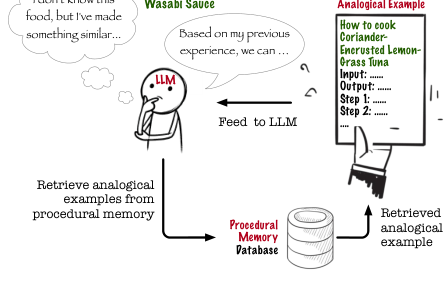


Document 2 (Type: image_description, Subtype: pymupdf_semantic_figure, CaptionID: p0_raster0)
  Content (Description/Caption): This visual element is a **conceptual diagram or illustration**, presented in a simple, hand-drawn style. **Key Visual Components:** * **Main Object:** A rectangular piece of paper or card, oriented vertically. * **Holding Element:** A hand, drawn in a minimalist, cartoon-like style (showing a thumb...
  Saved Image: page1_SEMANTIC_p0_raster0.png


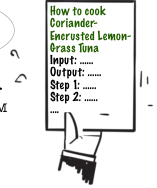

In [43]:
# Example of running it on a page:
print(f"\n--- Semantic Visual Element Extraction and Description Demo ---")
# Reset VLM counter for this specific demo if you want to ensure VLM calls happen
global images_described_this_run_count; images_described_this_run_count = 0

if PDF_PATHS and os.path.exists(PDF_PATHS[0]):
    demo_pdf_path = PDF_PATHS[0] # AAG.pdf
    demo_doc_fitz = fitz.open(demo_pdf_path)
    # Try a page known to have a figure, e.g., page 1 (index 0) of AAG.pdf for Figure 1
    # or page 4 (index 3) for Figure 2
    demo_page_num = 0
    if len(demo_doc_fitz) > demo_page_num:
        # Define a specific save directory for this demo page's images
        pdf_basename_demo = os.path.splitext(os.path.basename(demo_pdf_path))[0]
        demo_page_image_save_dir = os.path.join(IMAGE_SAVE_PARENT_DIR, f"{pdf_basename_demo}_page{demo_page_num+1}_demo_elements")
        if os.path.exists(demo_page_image_save_dir): shutil.rmtree(demo_page_image_save_dir)
        os.makedirs(demo_page_image_save_dir, exist_ok=True)

        processed_captions_for_demo_pdf_page = set() # Track for this single PDF's processing in demo

        visual_docs_from_demo_page = extract_visual_elements_pymupdf(
            demo_doc_fitz,
            demo_page_num,
            demo_page_image_save_dir, # Pass the specific directory for this page's images
            processed_captions_for_demo_pdf_page # Pass the set
        )

        print(f"\nGenerated {len(visual_docs_from_demo_page)} document objects from semantic visual extraction on page {demo_page_num+1}:")
        for i, v_doc in enumerate(visual_docs_from_demo_page):
            print(f"\nDocument {i+1} (Type: {v_doc.metadata.get('type')}, Subtype: {v_doc.metadata.get('element_subtype')}, CaptionID: {v_doc.metadata.get('caption_id')})")
            print(f"  Content (Description/Caption): {v_doc.page_content[:300]}...")
            if v_doc.metadata.get("image_path"):
                print(f"  Saved Image: {os.path.basename(v_doc.metadata['image_path'])}")
                try:
                    from IPython.display import Image as IPImage, display
                    display(IPImage(filename=v_doc.metadata['image_path'], width=200)) # Smaller display
                except ImportError:
                    print("IPython.display not available to show image in notebook.")
        demo_doc_fitz.close()
    else:
        print(f"PDF {demo_pdf_path} has less than {demo_page_num+1} pages.")
else:
    print(f"PDF path {PDF_PATHS[0] if PDF_PATHS else 'N/A'} not found or PDF_PATHS is empty for demo.")

## 8. Orchestrating the Hybrid Extraction Process

Now that we have the per-page visual extractor (`extract_visual_elements_pymupdf` or your chosen name) and other utilities, we need functions to manage the processing for entire files and then for all PDFs in our corpus. These correspond to `extract_elements_from_file` and `extract_elements_from_all_pdfs` that i will difine below.

### 8.1: Per-File Hybrid Extraction Function


In [46]:
def extract_elements_from_file(
    file_path: str,
    base_image_save_dir_for_this_file: str, # e.g., IMAGE_SAVE_PARENT_DIR/pdf_name_runid
    # llm_vlm_for_description: Optional[ChatGoogleGenerativeAI], # Uses global llm_aux
    text_splitter_to_use: RecursiveCharacterTextSplitter,
    processed_captions_tracker_for_this_pdf: Set[str] # To track captions within this single PDF
) -> Tuple[List[Document], Dict[str, Any]]: # Returns (docs_from_file, file_metadata_summary)
    """
    Extracts elements (text chunks, image descriptions) from a single file (PDF or image),
    handling digital and scanned PDFs. This is the notebook version of the logic.
    Uses `extract_visual_elements_pymupdf` (or your equivalent) for visual parts.
    Uses `generate_detailed_image_description` for VLM.
    """
    print(f"\nProcessing file with Hybrid v11.5 logic (Notebook): {os.path.basename(file_path)}")
    if not os.path.exists(base_image_save_dir_for_this_file):
        os.makedirs(base_image_save_dir_for_this_file, exist_ok=True)

    final_documents_from_file: List[Document] = []
    file_metadata_summary = {
        "title": "N/A", "abstract": "N/A", "source_filename": os.path.basename(file_path),
        "is_scanned": False, "page_count": 0
    }
    
    # Reset VLM counter at the start of processing each PDF file if you want the limit per PDF
    # global images_described_this_run_count; images_described_this_run_count = 0
    # Or manage it per PDF if `extract_elements_from_all_pdfs` handles multiple files.
    # For now, assuming the global counter is reset by the orchestrator for each file if desired,
    # or the limit in generate_detailed_image_description is a global run limit.
    # Let's refine: the MAX_ELEMENTS_FOR_VLM_DESCRIPTION_PER_PDF_EXPLORE implies a per-PDF limit.
    # So, the calling function (extract_elements_from_all_pdfs) should reset the global counter.

    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == ".pdf":
        try:
            doc_fitz = fitz.open(file_path)
            file_metadata_summary["page_count"] = len(doc_fitz)

            # --- Metadata Extraction (Title/Abstract from your notebook) ---
            if len(doc_fitz) > 0:
                first_page_meta = doc_fitz.load_page(0); page_height = first_page_meta.rect.height;
                title_candidates = []; blocks = first_page_meta.get_text("dict", flags=fitz.TEXTFLAGS_DICT)["blocks"]
                max_overall_font_size = 0; eligible_title_blocks_data = []
                for block in blocks:
                    if block['type'] == 0 and 0.03 * page_height < block['bbox'][1] < 0.40 * page_height:
                        for line in block['lines']:
                            for span in line['spans']:
                                if span['size'] > max_overall_font_size + 1e-3: max_overall_font_size = span['size']
                                eligible_title_blocks_data.append({'text': span['text'], 'size': span['size'], 'block_text': clean_parsed_text("".join(s['text'] for li in block['lines'] for s in li['spans']))})
                pymupdf_title = ""
                if max_overall_font_size > 13:
                    for data in eligible_title_blocks_data:
                        if abs(data['size'] - max_overall_font_size) < 1.0 and \
                           not re.match(r"arxiv:[\d\.]+", data['block_text'].lower(), re.I) and \
                           not re.search(r"\d{1,2}\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\w*\s+\d{4}", data['block_text'].lower(), re.I) and \
                           len(data['text'].strip()) > 2:
                            title_candidates.append(data['text'].strip())
                if title_candidates: pymupdf_title = clean_parsed_text(" ".join(list(dict.fromkeys(title_candidates))[:2]))
                if pymupdf_title:
                    file_metadata_summary["title"] = pymupdf_title
                    final_documents_from_file.append(Document(page_content=f"DOCUMENT TITLE: {pymupdf_title}", metadata={"source": file_path, "page_number": 1, "type": "title_summary", "importance": "critical", "parser_source": "pymupdf_meta_nb"}))

                abs_text_sorted = first_page_meta.get_text("text", sort=True)
                abs_match = re.search(r"Abstract\s*\n(.*?)(?=\n\s*\n(1\.(?:\s|\n)|I\.(?:\s|\n)|Keywords|Introduction|Motivation)\b)", abs_text_sorted, re.I | re.S)
                if abs_match:
                    pymupdf_abstract = clean_parsed_text(abs_match.group(1))
                    if pymupdf_abstract and len(pymupdf_abstract) > 50:
                        file_metadata_summary["abstract"] = pymupdf_abstract
                        final_documents_from_file.append(Document(page_content=f"DOCUMENT ABSTRACT: {pymupdf_abstract}", metadata={"source": file_path, "page_number": 1, "type": "abstract_summary", "importance": "critical", "parser_source": "pymupdf_meta_nb"}))
            # --- End Metadata Extraction ---

            # Check if scanned
            digitally_extracted_text_sample = "".join(doc_fitz.load_page(i).get_text("text", sort=True) for i in range(min(3, len(doc_fitz))))
            if len(clean_parsed_text(digitally_extracted_text_sample)) < MIN_OCR_TEXT_LENGTH_FOR_SCANNED_PDF * min(3, len(doc_fitz)):
                file_metadata_summary["is_scanned"] = True
                print(f"PDF '{os.path.basename(file_path)}' appears scanned. OCR will be used for text.")

            for page_num in tqdm(range(len(doc_fitz)), desc=f"Pages for {os.path.basename(file_path)}", leave=False):
                page = doc_fitz.load_page(page_num)
                page_text_for_chunking = ""
                parser_source_log = "pymupdf_digital_nb"

                if file_metadata_summary["is_scanned"]:
                    parser_source_log = "pymupdf_ocr_nb"
                    ocr_img_path = os.path.join(base_image_save_dir_for_this_file, f"page{page_num+1}_ocr_temp.png")
                    pix = page.get_pixmap(dpi=OCR_DPI, alpha=False); pix.save(ocr_img_path); pix = None
                    page_text_for_chunking = ocr_image_to_text(ocr_img_path) # Uses helper
                    # VLM for full scanned page (optional, as in your notebook)
                    page_img_desc = generate_detailed_image_description(ocr_img_path, "scanned page") # Uses helper
                    if "VLM description skipped" not in page_img_desc and "Error in VLM" not in page_img_desc :
                         final_documents_from_file.append(Document(page_content=page_img_desc,metadata={"source":file_path,"page_number":page_num+1,"type":"image_description","image_path":ocr_img_path,"original_caption":f"Full Scanned Page {page_num+1}","element_subtype":"scanned_page_full_nb","caption_id":f"ScannedPage{page_num+1}_Full_NB"}))
                else: # Digital PDF
                    page_text_for_chunking = page.get_text("text", sort=True)
                    # Call your semantic visual extractor (defined in Cell 4.3)
                    visual_docs_from_page = extract_visual_elements_pymupdf( # Or your chosen name
                        doc_fitz, page_num, base_image_save_dir_for_this_file, processed_captions_tracker_for_this_pdf
                    )
                    final_documents_from_file.extend(visual_docs_from_page)

                cleaned_page_text = clean_parsed_text(page_text_for_chunking) # Uses helper
                if cleaned_page_text:
                    text_to_process = cleaned_page_text
                    if page_num == 0 and file_metadata_summary["title"] != "N/A": # Add title context
                        if not cleaned_page_text.strip().lower().startswith(file_metadata_summary["title"].strip().lower()[:30]):
                             text_to_process = f"Document Title Context: {file_metadata_summary['title']}\n\n{cleaned_page_text}"
                    page_splits = text_splitter_to_use.create_documents([text_to_process], metadatas=[{"source":file_path, "page_number":page_num+1, "type":"text_chunk", "parser_source":parser_source_log}])
                    final_documents_from_file.extend(page_splits)
            doc_fitz.close()
        except Exception as e:
            print(f"Error processing PDF {file_path}: {e}")
            if 'doc_fitz' in locals() and doc_fitz.is_open: doc_fitz.close()


    elif file_extension in [".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tiff"]: # Standalone image
        print(f"Processing standalone image: {os.path.basename(file_path)}")
        file_metadata_summary["title"] = f"Image: {os.path.basename(file_path)}"
        file_metadata_summary["is_scanned"] = True # Treat as needing OCR/VLM
        ocr_text = ocr_image_to_text(file_path) # Uses helper
        if ocr_text:
            splits = text_splitter_to_use.create_documents([ocr_text],metadatas=[{"source":file_path,"page_number":1,"type":"text_chunk","parser_source":"image_ocr_nb"}])
            final_documents_from_file.extend(splits)
        img_desc = generate_detailed_image_description(file_path, "standalone image") # Uses helper
        if "VLM description skipped" not in img_desc and "Error in VLM" not in img_desc:
            final_documents_from_file.append(Document(page_content=img_desc,metadata={"source":file_path,"page_number":1,"type":"image_description","image_path":file_path,"original_caption":f"Standalone Image: {os.path.basename(file_path)}","element_subtype":"standalone_image_vlm_nb","caption_id":f"StandaloneImg_{os.path.basename(file_path)}_NB"}))
    else:
        print(f"Unsupported file type (Notebook): {file_path}")

    # Deduplication (from your notebook)
    final_deduped_documents: List[Document] = []; seen_keys = set()
    for doc_item in final_documents_from_file:
        key_parts = [doc_item.metadata.get("type"), doc_item.metadata.get("page_number"), doc_item.metadata.get("source")]
        content_key_part = doc_item.page_content[:150]
        if doc_item.metadata.get("type") == "image_description": content_key_part = doc_item.metadata.get("image_path", content_key_part)
        elif doc_item.metadata.get("type") in ["text_table_content", "text_figure_description"]: content_key_part = doc_item.metadata.get("caption_id", content_key_part)
        key_parts.append(content_key_part); key = tuple(key_parts)
        if key not in seen_keys: final_deduped_documents.append(doc_item); seen_keys.add(key)

    print(f"Finished file {os.path.basename(file_path)} (Hybrid Notebook): Extracted {len(final_deduped_documents)} unique elements.")
    return final_deduped_documents, file_metadata_summary

print("Per-file hybrid extraction function defined.")

Per-file hybrid extraction function defined.


### 8.2: Corpus-Level Orchestrator and Vector Store Creation Functions


In [47]:

def extract_elements_from_all_pdfs(
    list_of_file_paths: List[str],
    base_save_dir_for_all_outputs: str, # e.g., IMAGE_SAVE_PARENT_DIR
    # aux_llm_for_summaries_vlm: Optional[ChatGoogleGenerativeAI] # Uses global llm_aux
) -> Tuple[List[Document], str]: # Returns (all_docs_across_corpus, corpus_summary_text)
    """
    Orchestrates element extraction from multiple files for the notebook
    and generates a corpus summary. Uses global `llm_aux`.
    """
    all_docs_across_files: List[Document] = []
    corpus_summary_texts_for_llm: List[str] = []
    
    global images_described_this_run_count # Reset for each call to this orchestrator if desired
    images_described_this_run_count = 0 # Reset VLM usage for the whole corpus processing run

    # No global RUN_ID based cleanup here, caller of this function (main notebook block) handles it
    # os.makedirs(base_save_dir_for_all_outputs, exist_ok=True) # Ensure base output dir exists

    hybrid_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=300) # As in your notebook

    for file_path in list_of_file_paths:
        if not os.path.exists(file_path):
            print(f"File NOT FOUND: {file_path}, skipping.")
            continue

        file_basename_no_ext = os.path.splitext(os.path.basename(file_path))[0]
        # Create a specific subdirectory for this file's extracted images within the base_save_dir
        file_specific_image_save_dir = os.path.join(base_save_dir_for_all_outputs, f"{file_basename_no_ext}_elements")
        # No RUN_ID here, as base_save_dir_for_all_outputs might already be unique per run
        
        processed_captions_for_this_pdf = set() # Fresh set for each PDF

        elements_from_current_file, current_file_meta = extract_elements_from_file(
            file_path,
            file_specific_image_save_dir,
            hybrid_text_splitter,
            processed_captions_for_this_pdf
        )
        all_docs_across_files.extend(elements_from_current_file)

        title_to_use = current_file_meta.get("title", "N/A")
        abstract_to_use = current_file_meta.get("abstract", "N/A")
        if title_to_use != "N/A":
            corpus_summary_texts_for_llm.append(f"File:{file_basename_no_ext}, Title:{title_to_use}")
        if abstract_to_use != "N/A" and len(abstract_to_use) > 50:
            corpus_summary_texts_for_llm.append(f"Abstract({file_basename_no_ext}):{abstract_to_use[:200]}...")
        # Add sample content if title/abstract are missing (from your notebook)
        if title_to_use == "N/A":
            samples = [d.page_content for d in elements_from_current_file if d.metadata.get("type")=="text_chunk" and len(d.page_content)>150]
            if samples: corpus_summary_texts_for_llm.extend([f"SampleContent({file_basename_no_ext}):{s[:150]}..." for s in samples[:2]])


    corpus_summary_content = "Corpus summary: Default - no content or summarization failed."
    if llm_aux and corpus_summary_texts_for_llm: # Check if llm_aux is available
        try:
            summary_input_text = "\n".join(corpus_summary_texts_for_llm[:15]) # Limit input length
            prompt_text = ("Generate a concise overall summary of a document corpus based on these (potentially partial) titles, abstracts, and text samples:\n\n" + summary_input_text)
            if len(prompt_text) > 30000 : prompt_text = prompt_text[:30000] # Safeguard
            resp = llm_aux.invoke([HumanMessage(content=prompt_text)])
            corpus_summary_content = f"OVERALL CORPUS SUMMARY:\n{clean_parsed_text(resp.content)}"
        except Exception as e:
            print(f"Corpus summary generation error: {e}")
            corpus_summary_content = f"Corpus summary generation failed. Processed {len(list_of_file_paths)} file(s)."

    # Remove any old corpus summary and add the new one
    all_docs_across_files = [d for d in all_docs_across_files if d.metadata.get("type") != "corpus_summary"]
    corpus_doc = Document(page_content=corpus_summary_content, metadata={"source":"corpus_summary_nb", "type":"corpus_summary", "importance":"critical"})
    all_docs_across_files.insert(0, corpus_doc) # Add to the beginning

    print(f"\nCorpus Summary (Notebook): {corpus_summary_content[:300]}...")
    print(f"Total elements extracted from all files (Notebook): {len(all_docs_across_files)}")
    return all_docs_across_files, corpus_summary_content


def create_advanced_vector_stores(
    docs: List[Document],
    text_embedding_model: Optional[GoogleGenerativeAIEmbeddings], # Should be global 'embeddings'
    chroma_text_persist_path: str, # e.g., CHROMA_TEXT_PATH_NOTEBOOK_RUN
    chroma_image_desc_persist_path: str # e.g., CHROMA_IMAGE_DESC_PATH_NOTEBOOK_RUN
) -> Tuple[Optional[Any], Optional[Any]]: # Returns (text_retriever, image_desc_retriever)
    """Creates Chroma vector stores for text and image descriptions for the notebook run."""
    text_retriever_vs = None; image_desc_retriever_vs = None
    if not text_embedding_model:
        print("ERROR (Notebook VS Creation): Embedding model not available.")
        return None, None

    text_docs_for_vs = [d for d in docs if d.metadata.get("type") in ["text_chunk", "title_summary", "abstract_summary", "corpus_summary", "text_table_content", "text_figure_description"]]
    # In your notebook, "table_html_content" and "other_element_text" were also included. Add if needed.
    img_desc_docs_for_vs = [d for d in docs if d.metadata.get("type") == "image_description"]

    print(f"Docs for text VS (NB): {len(text_docs_for_vs)}, Docs for image_desc VS (NB): {len(img_desc_docs_for_vs)}")

    # Text Vector Store
    if text_docs_for_vs:
        # Caller (main notebook block) should handle rmtree for these paths
        # if os.path.exists(chroma_text_persist_path): shutil.rmtree(chroma_text_persist_path)
        # os.makedirs(chroma_text_persist_path, exist_ok=True)
        try:
            txt_vs = Chroma.from_documents(
                text_docs_for_vs, text_embedding_model,
                # collection_name=f"text_coll_adv_nb_{os.path.basename(chroma_text_persist_path)}", # Unique name
                persist_directory=chroma_text_persist_path
            )
            text_retriever_vs = txt_vs.as_retriever(search_type="similarity", search_kwargs={"k": 10}) # k from notebook
            print(f"Text VS created (NB): {txt_vs._collection.count()} entries at {chroma_text_persist_path}")
        except Exception as e: print(f"Error creating text vector store (NB): {e}")
    else: print("No text documents for vector store (NB).")

    # Image Description Vector Store
    if img_desc_docs_for_vs:
        # if os.path.exists(chroma_image_desc_persist_path): shutil.rmtree(chroma_image_desc_persist_path)
        # os.makedirs(chroma_image_desc_persist_path, exist_ok=True)
        try:
            img_vs = Chroma.from_documents(
                img_desc_docs_for_vs, text_embedding_model,
                # collection_name=f"img_desc_coll_adv_nb_{os.path.basename(chroma_image_desc_persist_path)}",
                persist_directory=chroma_image_desc_persist_path
            )
            image_desc_retriever_vs = img_vs.as_retriever(search_kwargs={"k": 8}) # k from notebook
            print(f"Image Desc VS created (NB): {img_vs._collection.count()} entries at {chroma_image_desc_persist_path}")
        except Exception as e: print(f"Error creating image description vector store (NB): {e}")
    else: print("No image description documents for vector store (NB).")

    return text_retriever_vs, image_desc_retriever_vs

print("Corpus-level orchestration and vector store functions defined.")

Corpus-level orchestration and vector store functions defined.


## 9. The VTIERP Hybrid Extraction Strategy

1.  **Metadata Extraction:** Title and Abstract extraction using PyMuPDF heuristics.
2.  **Digital Text Extraction:** For native PDFs, direct text extraction page by page.
3.  **OCR for Scanned PDFs:** If a PDF appears scanned, OCR is applied per page (using Unstructured.io if available, or a placeholder).
4.  **Semantic Visual Element Processing (as shown above):**
    *   Extraction of visual primitives.
    *   Caption association.
    *   Extraction of textual table content.
    *   Rendering of semantic visual groups.
    *   VLM-based description generation for rendered visuals (up to a limit).
5.  **Text Chunking:** All extracted textual content (page text, title, abstract, textual table content) is chunked.
6.  **Corpus Summary Generation:** An auxiliary LLM generates a high-level summary of the entire processed corpus.
7.  **Deduplication:** A final deduplication step ensures unique document elements.

This comprehensive approach aims to capture as much relevant information as possible from diverse PDF structures.

In [48]:
# Cell 9 (or later): Running Full Hybrid Extraction and Vector Store Creation
# This is where your error occurred (NameError for extract_elements_from_all_pdfs_advanced)

print("\n--- Running Full Hybrid Extraction and Vector Store Creation (Notebook Flow) ---")
global images_described_this_run_count; images_described_this_run_count = 0 # Reset global for this full run

# Define base paths for this notebook run's outputs (previously missing)
# CHROMA_TEXT_PATH and CHROMA_IMAGE_DESC_PATH were defined in Cell 2 as:
# CHROMA_TEXT_PATH_NOTEBOOK = os.path.join(EXPLORATION_OUTPUT_BASE, "chroma_db_text")
# CHROMA_IMAGE_DESC_PATH_NOTEBOOK = os.path.join(EXPLORATION_OUTPUT_BASE, "chroma_db_img_desc")
# IMAGE_SAVE_PARENT_DIR is also from Cell 2.

# Create unique RUN_ID specific paths for this execution block if you want isolation
# within the notebook for multiple runs of this particular cell.
# Otherwise, use CHROMA_TEXT_PATH_NOTEBOOK and CHROMA_IMAGE_DESC_PATH_NOTEBOOK directly.
# The original code had RUN_ID logic, let's replicate that for this block:
RUN_ID_FULL_EXTRACTION = uuid.uuid4().hex[:8]
IMAGE_SAVE_PARENT_DIR_RUN = os.path.join(IMAGE_SAVE_PARENT_DIR, f"run_{RUN_ID_FULL_EXTRACTION}") # Subfolder for images of this run
CHROMA_TEXT_PATH_RUN = os.path.join(CHROMA_TEXT_PATH_NOTEBOOK, f"run_{RUN_ID_FULL_EXTRACTION}") # Subfolder for text DB
CHROMA_IMAGE_DESC_PATH_RUN = os.path.join(CHROMA_IMAGE_DESC_PATH_NOTEBOOK, f"run_{RUN_ID_FULL_EXTRACTION}") # Subfolder for image DB

# Clean up specific run directories
if os.path.exists(IMAGE_SAVE_PARENT_DIR_RUN): shutil.rmtree(IMAGE_SAVE_PARENT_DIR_RUN)
if os.path.exists(CHROMA_TEXT_PATH_RUN): shutil.rmtree(CHROMA_TEXT_PATH_RUN)
if os.path.exists(CHROMA_IMAGE_DESC_PATH_RUN): shutil.rmtree(CHROMA_IMAGE_DESC_PATH_RUN)

# Explicitly create them now
os.makedirs(IMAGE_SAVE_PARENT_DIR_RUN, exist_ok=True)
os.makedirs(CHROMA_TEXT_PATH_RUN, exist_ok=True)
os.makedirs(CHROMA_IMAGE_DESC_PATH_RUN, exist_ok=True)


# Call the _notebook suffixed functions defined in Cell 8.1 and 8.2
all_extracted_elements, overall_corpus_summary = extract_elements_from_all_pdfs(
    PDF_PATHS, # Defined in Cell 2
    IMAGE_SAVE_PARENT_DIR_RUN, # Use the run-specific image save dir
    # llm_aux is used globally by the function
)

# text_retriever and image_desc_retriever will be made global for LangGraph nodes to use
# Or, pass them explicitly into LangGraph state if you prefer that pattern.
# For notebook simplicity, making them global is often easier.
text_retriever = None
image_desc_retriever = None

if all_extracted_elements and embeddings: # Check if embeddings model is available
    text_retriever, image_desc_retriever = create_advanced_vector_stores(
        all_extracted_elements,
        embeddings, # Defined in Cell 2
        CHROMA_TEXT_PATH_RUN, # Use run-specific path
        CHROMA_IMAGE_DESC_PATH_RUN # Use run-specific path
    )
else:
    print("Skipping vector store creation: No extracted elements or embeddings model missing.")

if text_retriever:
    print("Global `text_retriever` successfully created for LangGraph.")
if image_desc_retriever:
    print("Global `image_desc_retriever` successfully created for LangGraph.")


--- Running Full Hybrid Extraction and Vector Store Creation (Notebook Flow) ---

Processing file with Hybrid v11.5 logic (Notebook): AAG.pdf


Pages for AAG.pdf:   0%|          | 0/21 [00:00<?, ?it/s]

Finished file AAG.pdf (Hybrid Notebook): Extracted 88 unique elements.

Processing file with Hybrid v11.5 logic (Notebook): Self_rewarding_VLLM.pdf


Pages for Self_rewarding_VLLM.pdf:   0%|          | 0/18 [00:00<?, ?it/s]

Finished file Self_rewarding_VLLM.pdf (Hybrid Notebook): Extracted 82 unique elements.

Corpus Summary (Notebook): OVERALL CORPUS SUMMARY:
This corpus details advanced AI systems focused on **generative tasks** and **problem-solving**. It includes **Analogy-Augmented Generation (AAG)**, which leverages procedural memory and past experiences for procedural Q&A and generating novel outputs like recipes. Additional...
Total elements extracted from all files (Notebook): 171
Docs for text VS (NB): 149, Docs for image_desc VS (NB): 22
Text VS created (NB): 149 entries at /home/dipesh/WORKSPACE/LET's Learn/vtierp_project/notebooks/exploration_outputs/chroma_db_text/run_f6194d69
Image Desc VS created (NB): 22 entries at /home/dipesh/WORKSPACE/LET's Learn/vtierp_project/notebooks/exploration_outputs/chroma_db_img_desc/run_f6194d69
Global `text_retriever` successfully created for LangGraph.
Global `image_desc_retriever` successfully created for LangGraph.


## 10. VTIERP RAG Agent with LangGraph

Now, we construct the RAG agent using LangGraph to orchestrate the retrieval and generation process. The agent will:
1.  Potentially transform the input query.
2.  Retrieve relevant text chunks and image/table descriptions.
3.  Rerank and select the most pertinent context.
4.  Pass the selected text, image descriptions, and (optionally) actual image data to the LLM for answer generation.

In [50]:
from langgraph.graph import StateGraph, END
from typing import List, Dict, TypedDict, Optional, Any, Set # Ensure TypedDict is imported
from langchain_core.messages import HumanMessage, SystemMessage # Ensure these are imported
from langchain.docstore.document import Document # Ensure this is imported
import os # Ensure os is imported for path operations
from collections import defaultdict # For format_docs_for_llm

# --- 1. LangGraph State Definition ---
class AdvancedRAGState(TypedDict):
    """Represents the state of our RAG pipeline for the notebook."""
    original_question: str
    transformed_question: str
    retrieved_text_docs: List[Document]
    retrieved_image_desc_docs: List[Document]
    final_text_context: List[Document]
    final_image_context: List[Document]
    images_for_llm_payload: List[Dict[str, Any]] # For base64 images if passed to LLM
    answer: str
    # Use the globally available 'overall_corpus_summary' string directly in nodes
    # instead of passing it through state, or add it to state if preferred.
    # For simplicity here, nodes will access the global 'overall_corpus_summary'.

print("AdvancedRAGState defined.")

# --- 2. Helper: Format Documents for LLM Context ---
def format_docs_for_llm(docs: List[Document], doc_type_label: str) -> str:
    """
    Formats a list of Langchain Document objects into a readable string for the LLM context.
    (Adapted from your notebook's `format_docs_for_llm` logic)
    """
    if not docs:
        return f"No relevant {doc_type_label} context found for this query."

    if doc_type_label == "image descriptions":
        grouped_by_caption_id = defaultdict(list)
        for doc in docs:
            # Using caption_id for grouping image descriptions. Fallback for safety.
            caption_id = doc.metadata.get("caption_id", f"ungrouped_img_desc_{os.path.basename(doc.metadata.get('image_path','no_path'))}")
            grouped_by_caption_id[caption_id].append(doc)

        formatted_parts = []
        for cap_id, desc_docs in grouped_by_caption_id.items():
            # Get original caption from the first doc in the group (should be consistent)
            original_caption_text = desc_docs[0].metadata.get("original_caption", str(cap_id))
            if "ungrouped_img_desc" in str(cap_id) and original_caption_text == str(cap_id):
                original_caption_text = "Ungrouped Visual Element"

            formatted_parts.append(f"Visual Element Group: '{original_caption_text[:100]}...' ({len(desc_docs)} VLM description(s) retrieved)")
            for i, single_desc_doc in enumerate(desc_docs):
                img_path_hint = os.path.basename(str(single_desc_doc.metadata.get('image_path','N/A')))
                page_num_hint = single_desc_doc.metadata.get('page_number','N/A')
                # The VLM description is the page_content of the image_description Document
                formatted_parts.append(f"  VLM Description Part {i+1} (Source Hint: {img_path_hint}, Page: {page_num_hint}):\n    {single_desc_doc.page_content}")
        return "\n\n".join(formatted_parts)

    # For general text documents (text_chunks, summaries, textual_table_content etc.)
    formatted_parts = []
    for i, doc in enumerate(docs):
        metadata = doc.metadata
        source_file = os.path.basename(str(metadata.get('source','N/A')))
        page_num = metadata.get('page_number','N/A')
        
        doc_kind_raw = metadata.get('parser_source', metadata.get('type', 'N/A'))
        # Simplify display name for doc_kind
        doc_kind_clean = str(doc_kind_raw).replace('text_', '').replace('_description', '').replace('_summary', '').replace('_nb', '').replace('pymupdf_meta', 'Metadata').replace('digital','Digital Text').replace('ocr','OCR Text').replace('content','')
        if doc_kind_clean == "chunk": doc_kind_clean = "Text Chunk"
        if doc_kind_clean == "corpus": doc_kind_clean = "Corpus Summary"


        importance_level = metadata.get('importance', '')
        header = f"Context Document {i+1} (Type: {doc_kind_clean}, Source: {source_file}, Page: {page_num}{', Importance: '+importance_level if importance_level else ''}):"
        formatted_parts.append(f"{header}\n{doc.page_content}\n")
    return "\n\n".join(formatted_parts)

print("format_docs_for_llm defined.")

# --- 3. LangGraph Nodes ---

# Node 1: Query Transformation (simple pass-through for now)
def query_transform_node(state: AdvancedRAGState) -> AdvancedRAGState:
    print("---LG Node: Query Transform---")
    # state["original_question"] should be set when invoking the graph
    state["transformed_question"] = state["original_question"]
    return state

# Node 2: Document Retrieval
def retrieve_documents_node(state: AdvancedRAGState) -> AdvancedRAGState:
    print("---LG Node: Retrieve Documents---")
    query = state["transformed_question"]
    
    # Access global retrievers (ensure they are created and populated before running graph)
    if 'text_retriever' in globals() and text_retriever:
        state["retrieved_text_docs"] = text_retriever.invoke(query)
        print(f"Retrieved {len(state['retrieved_text_docs'])} text documents.")
    else:
        state["retrieved_text_docs"] = []
        print("Warning: Global `text_retriever` not found or not initialized.")
        
    if 'image_desc_retriever' in globals() and image_desc_retriever:
        state["retrieved_image_desc_docs"] = image_desc_retriever.invoke(query)
        print(f"Retrieved {len(state['retrieved_image_desc_docs'])} image description documents.")
    else:
        state["retrieved_image_desc_docs"] = []
        print("Warning: Global `image_desc_retriever` not found or not initialized.")
    return state

# Node 3: Rerank and Select Context
def rerank_and_select_node(state: AdvancedRAGState) -> AdvancedRAGState:
    print("---LG Node: Rerank and Select---")
    retrieved_texts = state.get("retrieved_text_docs", [])
    retrieved_image_descs = state.get("retrieved_image_desc_docs", [])

    # Using k values from your notebook's retriever setup (or define desired final k here)
    # Your notebook used k=10 for text retriever, k=8 for image desc retriever.
    # And then selected k_txt=7, k_img=5 for final context.
    k_text_final = 7
    k_images_final = 5

    # Prioritize critical documents (corpus summary, title, abstract)
    final_text_selection = []
    critical_content_prefixes_seen = set() # To avoid adding very similar critical docs

    # Add corpus summary first if available (assuming it's important)
    # The corpus summary is already prepended in all_extracted_elements, so it should be retrieved if relevant.
    # We can specifically look for it in retrieved_texts or assume retriever handles its importance.
    
    # Simple prioritization: critical docs first, then others, up to k_text_final
    # This logic matches your notebook's rerank_and_select_node
    for doc in retrieved_texts:
        if doc.metadata.get("importance") == "critical":
            prefix = doc.page_content[:200]
            if prefix not in critical_content_prefixes_seen:
                final_text_selection.append(doc)
                critical_content_prefixes_seen.add(prefix)
    
    for doc in retrieved_texts:
        if doc.metadata.get("importance") != "critical":
            prefix = doc.page_content[:200]
            is_already_selected = any(sel_doc.page_content[:200] == prefix for sel_doc in final_text_selection)
            if not is_already_selected:
                final_text_selection.append(doc)
    
    state["final_text_context"] = final_text_selection[:k_text_final]
    state["final_image_context"] = retrieved_image_descs[:k_images_final]
    print(f"Selected {len(state['final_text_context'])} text and {len(state['final_image_context'])} image description contexts.")

    # Prepare image payload for LLM (if model can handle direct image input)
    # MAX_IMAGES_TO_LLM_FINAL is from Cell 2 config
    images_payload = []
    for img_desc_doc in state["final_image_context"][:MAX_IMAGES_TO_LLM_FINAL]:
        image_path = img_desc_doc.metadata.get("image_path") # Path to the rendered image
        if image_path and os.path.exists(image_path):
            b64_str, mime = image_to_base64(image_path) # Uses helper from Cell 4.1
            if b64_str and mime:
                images_payload.append({
                    "path": image_path,
                    "vlm_description": img_desc_doc.page_content, # The VLM desc of this image
                    "data": b64_str,
                    "mime_type": mime
                })
    state["images_for_llm_payload"] = images_payload
    print(f"Prepared {len(images_payload)} actual images for LLM payload (if model supports).")
    return state

# Node 4: Generate Answer
def generate_answer_advanced_node(state: AdvancedRAGState) -> AdvancedRAGState:
    print("---LG Node: Generate Answer---")
    question = state["original_question"]
    text_ctx_str = format_docs_for_llm(state.get("final_text_context", []), "textual")
    img_desc_ctx_str = format_docs_for_llm(state.get("final_image_context", []), "image descriptions")
    actual_images_for_llm = state.get("images_for_llm_payload", [])
    
    # Access global overall_corpus_summary (string, created by extract_elements_from_all_pdfs_advanced)
    # Ensure 'overall_corpus_summary' is in the global scope and populated.
    corpus_summary_context_str = "No global corpus summary available for this run."
    if 'overall_corpus_summary' in globals() and overall_corpus_summary:
        corpus_summary_context_str = f"--- OVERALL CORPUS SUMMARY ---\n{overall_corpus_summary}\n--- END CORPUS SUMMARY ---"


    # System prompt (adapted from your notebook's generate_answer_advanced_node)
    system_prompt = (
        "You are an expert AI research assistant. Your task is to provide comprehensive, accurate, "
        "and well-structured answers to user questions based *only* on the provided documents as context.\n\n"
        "**Context Prioritization:** Prioritize context explicitly labeled 'DOCUMENT TITLE:', 'DOCUMENT ABSTRACT:', or 'CORPUS SUMMARY:'.\n\n"
        "**Figure/Table Description:**\n"
        "- When asked to 'describe' a specific figure/table (e.g., 'Figure 1', 'Table 2'):\n"
        "    - **Prioritize 'image_description' documents or 'text_table_content' that have a matching 'caption_id'.** Consolidate if multiple parts exist.\n"
        "    - **If no direct VLM/image description is found but a 'text_figure_description' (caption text) is, describe based on that text.**\n"
        "    - **For visual descriptions from images, explain key components, structure, text within, and purpose.**\n\n"
        "**General Guidance:**\n"
        "- Maintain a neutral, informative tone.\n"
        "- If information is not found in the provided context, state that clearly.\n"
        "- Format your answer clearly (headings, bullets).\n"
        "- Cite page numbers (P:X) or source document names (S:filename) if available in metadata. Mention caption_id (e.g., Figure 1) if relevant.\n"
        "- You might be given context from multiple unrelated documents. Identify relevant pieces yourself."
    )

    human_message_content_parts = []
    human_message_content_parts.append({"type": "text", "text": corpus_summary_context_str})
    human_message_content_parts.append({"type": "text", "text": f"\n\n--- TEXTUAL & TEXTUAL TABLE CONTEXT ---\n{text_ctx_str}\n--- END TEXTUAL CONTEXT ---"})
    human_message_content_parts.append({"type": "text", "text": f"\n\n--- VLM DESCRIPTIONS OF VISUAL ELEMENTS ---\n{img_desc_ctx_str}\n--- END VLM DESCRIPTIONS ---"})

    if actual_images_for_llm:
        human_message_content_parts.append({"type": "text", "text": f"\n\n--- ({len(actual_images_for_llm)}) ACTUAL IMAGES ATTACHED FOR REFERENCE ---"})
        for i, img_data in enumerate(actual_images_for_llm):
            human_message_content_parts.append({"type": "text", "text": f"Attached Image {i+1} Ref ({os.path.basename(img_data['path'])}). Summary of its VLM Desc: '{img_data['vlm_description'][:100]}...'"})
            human_message_content_parts.append({"type": "image_url", "image_url": {"url": f"data:{img_data['mime_type']};base64,{img_data['data']}"}})
        human_message_content_parts.append({"type": "text", "text": "--- END ACTUAL IMAGES ---"})
    else:
        human_message_content_parts.append({"type": "text", "text": "\n\nNo actual images attached to this query for the model."})

    human_message_content_parts.append({"type": "text", "text": f"\n\n--- USER QUESTION ---\n{question}\n\n--- ANSWER (Based *only* on provided context) ---"})
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_message_content_parts)
    ]

    final_answer = "Error: RAG LLM not available or invocation failed."
    if 'llm_rag' in globals() and llm_rag: # Ensure llm_rag is defined
        try:
            response = llm_rag.invoke(messages)
            final_answer = response.content
        except Exception as e:
            final_answer = f"LLM generation error: {e}"
            print(f"Error during LLM answer generation: {e}")
            # import traceback; traceback.print_exc()
    else:
        print("Warning: Global `llm_rag` not found for answer generation.")
        
    state["answer"] = final_answer
    return state

print("LangGraph nodes defined.")

# --- 4. Build and Compile the LangGraph ---
workflow = StateGraph(AdvancedRAGState)

# Add nodes
workflow.add_node("query_transformer", query_transform_node)
workflow.add_node("document_retriever", retrieve_documents_node)
workflow.add_node("context_selector", rerank_and_select_node)
workflow.add_node("answer_generator", generate_answer_advanced_node)

# Define edges
workflow.set_entry_point("query_transformer")
workflow.add_edge("query_transformer", "document_retriever")
workflow.add_edge("document_retriever", "context_selector")
workflow.add_edge("context_selector", "answer_generator")
workflow.add_edge("answer_generator", END) # END is from langgraph.graph

# Compile the graph
app_advanced_rag = workflow.compile()
print("LangGraph RAG agent compiled successfully as 'app_advanced_rag'.")

# Optional: Visualize the graph
# This requires graphviz to be installed (pip install graphviz, and system install: sudo apt-get install graphviz)
# Also, ensure RUN_ID_FULL_EXTRACTION is defined from the previous cell if you use it in the path.
# If not, use a generic name or remove RUN_ID from path.
# For simplicity, let's use a fixed name for the graph image in the notebook.
graph_image_save_path = os.path.join(EXPLORATION_OUTPUT_BASE, "vtierp_langgraph.png")
try:
    # Ensure the directory for the image exists
    os.makedirs(os.path.dirname(graph_image_save_path), exist_ok=True)
    
    graph_png_data = app_advanced_rag.get_graph().draw_png()
    with open(graph_image_save_path, "wb") as f:
        f.write(graph_png_data)
    print(f"\nLangGraph visualization saved to: {graph_image_save_path}")
    
    # To display in notebook (if IPython is available)
    # from IPython.display import Image as IPImage, display
    # display(IPImage(filename=graph_image_save_path))
except ImportError:
    print("Skipping graph visualization display in notebook (IPython not available).")
except Exception as e:
    print(f"Could not draw or save LangGraph graph (is graphviz installed and in PATH?): {e}")

AdvancedRAGState defined.
format_docs_for_llm defined.
LangGraph nodes defined.
LangGraph RAG agent compiled successfully as 'app_advanced_rag'.



LangGraph visualization saved to: /home/dipesh/WORKSPACE/LET's Learn/vtierp_project/notebooks/exploration_outputs/vtierp_langgraph.png


## 11. Testing the VTIERP Agent

Let's test the agent with a variety of queries, including those that require understanding visual context.

In [51]:
# Cell 11: Testing the Advanced VTIERP RAG Agent (Notebook Version)

# Ensure AdvancedRAGState is defined (it should be from the previous LangGraph cell)
if 'AdvancedRAGState' not in globals():
    print("Error: AdvancedRAGState TypedDict is not defined. Please run the LangGraph definition cell.")
    # You might want to stop execution here or define it again if necessary
    # For example:
    # from typing import List, Dict, TypedDict, Optional, Any, Set
    # class AdvancedRAGState(TypedDict):
    #     original_question: str
    #     transformed_question: str
    #     retrieved_text_docs: List[Document]
    #     retrieved_image_desc_docs: List[Document]
    #     final_text_context: List[Document]
    #     final_image_context: List[Document]
    #     images_for_llm_payload: List[Dict[str, Any]]
    #     answer: str


# Ensure the compiled LangGraph app is available
if 'app_advanced_rag' not in globals():
    print("Error: `app_advanced_rag` (compiled LangGraph) is not defined. Please run the LangGraph definition and compilation cell.")
    # Stop execution or handle
    raise NameError("`app_advanced_rag` is not defined.")

# Ensure overall_corpus_summary is available
if 'overall_corpus_summary' not in globals():
    print("Warning: `overall_corpus_summary` is not defined globally. The agent might not have corpus-level summary context for prompts.")
    # Set a default if it's missing, though it's better if the previous cell populates it.
    overall_corpus_summary = "Corpus summary not available for this test run."


# --- Define Test Queries (same as in your original notebook) ---
test_queries_adv = [
    "What is the full form of AAG and what does its abstract say about its purpose?",
    "Describe Figure 1 in AAG.pdf visually and explain its significance based on surrounding text or VLM description.",
    "Summarize the data presented in any tables on page 6 of AAG.pdf. What are the key column headers and data trends?", # Your notebook had "Table 1 on page 6"
    "What methodology is shown in any diagrams within the first few pages of AAG.pdf?",
    "Describe me what does the LCStep MEANT IN THIS research paper ",
    "Analyze the Table 1 in details and then summerize what does the data inside this table trying to convey", # This query might still fail if Table 1 isn't explicitly found/described as such
    "Replicate or visualize show both table 1 and table 2 , exactly how it's on the paper.", # This might be hard for LLM without explicit table data matching the exact name
    "What's difference between Table 1 and Table 2?",
    "Explain figure 4 in detail",
    "How many different research papers have I uploaded to you for processing in this corpus?", # Adjusted for clarity
    "How are the different papers in this corpus (AAG.pdf and Self_rewarding_VLLM.pdf) similar and different in their core ideas?" # Adjusted for clarity
]

print(f"\n--- Starting Test Queries for Advanced VTIERP RAG Agent ('app_advanced_rag') ---")

for i, query in enumerate(test_queries_adv):
    print(f"\n\n--- Test Query {i+1} ---")
    print(f"QUESTION: {query}")

    # Prepare the initial input dictionary for the LangGraph state.
    # All keys from AdvancedRAGState must be present.
    # The LangGraph invoke method expects a dictionary that can initialize the state.
    # The `overall_corpus_summary` is accessed globally by the nodes, not passed via state here.
    
    # Initialize state dictionary with default values for all keys in AdvancedRAGState
    initial_input_state = {}
    try:
        for key_name, type_hint in AdvancedRAGState.__annotations__.items():
            # Basic default value initialization based on common types
            origin = getattr(type_hint, '__origin__', None)
            if origin is list or str(type_hint).startswith("typing.List") or str(type_hint).startswith("List["):
                initial_input_state[key_name] = []
            elif origin is dict or str(type_hint).startswith("typing.Dict") or str(type_hint).startswith("Dict["):
                initial_input_state[key_name] = {}
            elif origin is Optional or (hasattr(type_hint, '__args__') and type(None) in type_hint.__args__): # Handles Optional[T]
                initial_input_state[key_name] = None
            elif type_hint is str:
                initial_input_state[key_name] = ""
            else: # Fallback for other types, though state usually sticks to these
                initial_input_state[key_name] = None # Or raise an error if an unknown type
    except NameError: # If AdvancedRAGState wasn't found initially
        print("CRITICAL ERROR: AdvancedRAGState not defined. Cannot initialize input for LangGraph. Stopping tests.")
        break # Exit the loop

    # Set the essential starting values
    initial_input_state["original_question"] = query
    # transformed_question will be set by the first node
    # other fields like retrieved_docs, answer will be populated by the graph

    try:
        # Invoke the compiled LangGraph application
        # The 'config' dictionary can be used for things like recursion limits, thread pool executors, etc.
        config = {"recursion_limit": 15} # As in your original notebook
        
        # Ensure `app_advanced_rag` is the correct compiled graph object
        final_state_result = app_advanced_rag.invoke(initial_input_state, config=config)
        
        answer = final_state_result.get('answer', 'No answer was generated or found in the final state.')
        print(f"\nANSWER:\n{answer}")

        # Optional: Print some of the context used (for debugging)
        # print("\n--- Context Used (Sample) ---")
        # if final_state_result.get("final_text_context"):
        #     print("Text Context:")
        #     for doc_ctx in final_state_result["final_text_context"][:2]: # Print first 2 text contexts
        #         print(f"  - Source: {doc_ctx.metadata.get('source', 'N/A')}, Page: {doc_ctx.metadata.get('page_number', 'N/A')}")
        #         print(f"    Content: {doc_ctx.page_content[:150]}...")
        # if final_state_result.get("final_image_context"):
        #     print("Image Description Context:")
        #     for img_ctx_doc in final_state_result["final_image_context"][:2]: # Print first 2 image contexts
        #         print(f"  - Caption ID: {img_ctx_doc.metadata.get('caption_id', 'N/A')}, Orig Caption: {img_ctx_doc.metadata.get('original_caption', 'N/A')[:70]}...")
        #         print(f"    VLM Desc: {img_ctx_doc.page_content[:150]}...")


    except Exception as e:
        print(f"\nERROR during LangGraph execution for query '{query}':")
        print(f"{e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging the error

print("\n\n--- All Test Queries for LangGraph Agent Finished ---")


--- Starting Test Queries for Advanced VTIERP RAG Agent ('app_advanced_rag') ---


--- Test Query 1 ---
QUESTION: What is the full form of AAG and what does its abstract say about its purpose?
---LG Node: Query Transform---
---LG Node: Retrieve Documents---
Retrieved 10 text documents.
Retrieved 8 image description documents.
---LG Node: Rerank and Select---
Selected 7 text and 5 image description contexts.
Prepared 3 actual images for LLM payload (if model supports).
---LG Node: Generate Answer---

ANSWER:
The full form of AAG is **Analogy-Augmented Generation** (S:corpus_summary_nb).

Based on the overall corpus summary, AAG's purpose is to leverage procedural memory and past experiences for procedural question-answering (Q&A) and for generating novel outputs, such as recipes (S:corpus_summary_nb).


--- Test Query 2 ---
QUESTION: Describe Figure 1 in AAG.pdf visually and explain its significance based on surrounding text or VLM description.
---LG Node: Query Transform---
---LG Node

## 12. Conclusion and Future Work

This exploration demonstrates the feasibility and benefits of a hybrid multimodal RAG system for research papers. By extracting and describing visual elements alongside textual content, VTIERP can provide more comprehensive answers to complex queries. The use of PyMuPDF for detailed element extraction, combined with Gemini for VLM-like descriptions and LangGraph for agentic control, forms a powerful foundation.

**Key Findings:**
*   Semantic grouping of visual primitives with their captions is crucial.
*   Generating textual descriptions for visuals (even simulated via VLM or good caption extraction) significantly enhances context for the LLM.
*   Textual table content can be effectively extracted and treated as text.
*   LangGraph provides excellent flexibility for orchestrating the multimodal RAG pipeline.

**Future Work:**
*   **True VLM Integration:** Replace simulated VLM descriptions with calls to actual advanced Vision-Language Models (e.g., Gemini Vision Pro directly for image understanding within the RAG chain if token limits/costs allow, or specialized image captioning/VQA models).
*   **Improved Table Understanding:** Integrate more robust table parsing libraries (e.g., `unstructured.io` table extraction, or dedicated table-to-text models).
*   **Advanced Query Decomposition:** For very complex queries, LangGraph could be used to decompose them into sub-queries for text and visual modalities.
*   **Enhanced UI:** Develop a user-friendly interface (e.g., using Streamlit) to interact with the VTIERP system.
*   **Scalability and Deployment:** Package the system into a deployable application (e.g., using FastAPI and Docker) following 12-Factor App principles.
*   **Rigorous Evaluation:** Conduct a more formal evaluation with a larger set of documents and queries, comparing against baseline RAG systems.

This notebook serves as the foundational research and experimentation leading to the development of the full VTIERP application.